# Maksymilian Wojnar

# Web crawler

W ramach zadania napisałem własnego web crawlera w oparciu o biblioteki requests (pobieranie stron) oraz BeautifoulSoup (parsowanie HTML). Jego zadaniem było pobieranie, zapisywanie na dysku oraz wstępne parsowanie stron internetowych, które stworzą bazę dokumentów. Z bazy tej będzie można wybierać odpowiedzi na pytania wprowadzane w mojej wyszukiwarce. Crawler rozpoczynał przeszukiwanie internetu od podanej strony początkowej i pobierał sekwencyjnie dokumenty (aż do osiągnięcia maksymalnej liczby stron lub przerwania działania). Zaimplementowałem również obsługę pliku "robots.txt", który określa reguły dostępu do zawartości strony dla robotów przeszukujących witryny. Kod crawlera zamieszam poniżej:

In [ ]:
from bs4 import BeautifulSoup
import requests

from urllib.robotparser import RobotFileParser
from urllib.parse import urlsplit, urljoin

from collections import deque
import sys


def get_robot(robots_url):
    global downloaded_robots

    if robots_url not in downloaded_robots:
        try:
            robots = RobotFileParser()
            robots.set_url(robots_url)
            robots.read()
            downloaded_robots[robots_url] = robots
        except Exception:
            downloaded_robots[robots_url] = None

    return downloaded_robots[robots_url]


if len(sys.argv) != 4:
    print("Incorrect number of args. Enter start_url, max_docs and file_names.")
    exit(1)

downloaded_robots = {}
visited = set()

queue = deque()
queue.append(sys.argv[1])

file_names = sys.argv[3]
max_docs = int(sys.argv[2])
downloaded_docs = 0

while len(queue) > 0 and downloaded_docs < max_docs:
    url = urlsplit(queue.popleft())
    robots_url = f'{url.scheme}://{url.netloc}/robots.txt'
    url = f'{url.scheme}://{url.netloc}{url.path}'

    if url in visited:
        continue

    robot = get_robot(robots_url)

    if robot is None or robot.can_fetch('*', url):
        try:
            document = requests.get(url)
        except Exception:
            continue

        soup = BeautifulSoup(document.content, 'html.parser')

        if soup.find("title") is None or soup.text is None:
            continue

        with open(f'./documents/{file_names}{downloaded_docs}.txt', 'w', encoding='utf-8') as file:
            file.write(f'{url}\n')
            file.write(f'{soup.find("title").string}\n')
            file.write(soup.get_text(separator=' ', strip=True))

        for a_tag in soup.find_all('a', href=True):
            link = a_tag['href']

            if urlsplit(link).scheme == '':
                link = urljoin(url, link)

            queue.append(link)

        downloaded_docs += 1
        visited.add(url)

Przeszukiwanie internetu rozpoczynałem od angielskich stron, które charakteryzowały się dużą liczbą odnośników do innych witryn, zawierały wiele informacji lub same były katalogami różnego rodzaju treści. Uruchamiałem wiele instancji crawlera jednocześnie z następującymi stronami początkowymi:

 - Wikipedia,
 
 - Merriam-Webster,
 
 - Amazon,
 
 - CNN,
 
 - Reuters,
 
 - Gutenberg,
 
 - IMDb,
 
 - Coursera,
 
 - msn,
 
 - The New York Times.

Instancje crawlera pobrały sumarycznie około 50.000 stron. Musiałem dokonać pewnej selekcji pobranych dokumentów, gdyż niektóre były pustymi stronami lub stronami błędu (np. zawierały samą informację "error 404"). Ponadto część stron była w innym języku, niż angielski, zatem musiałem je usunąć, aby nie zwiększać niepotrzebnie rozmiaru słownika (w domyśle wyszukiwarka działa tylko po angielsku). Wykorzystałem do tego poniższy skrypt z biblioteką langdetect:

In [ ]:
from langdetect import detect
import os


files = [file for file in os.listdir('.') if file.find('.txt') == -1]

for file in files:
    with open(file, encoding='utf-8') as reader:
        try:
            remove = detect(reader.read()) != 'en'
        except Exception:
            remove = True

    if remove:
        os.remove(f'./{file}')

Otrzymany zbiór dokumentów zawierał ostatecznie 45.752 witryny. Każda z nich była zapisana w pliku tekstowym w formacie:

 - 1 linia - link do strony,
 
 - 2 linia - tytuł strony,
 
 - pozostała część - tekst widoczny na stronie.
 
Na podstawie tej bazy zbudowałem silnik wyszukiwarki.

# Wyszukiwarka

Wyszukiwarka została zbudowana za pomocą bibliotek numpy (macierze), scipy (macierze rzadkie, SVD dla macierzy rzadkich), nltk (tokenizacja, stemming, stoplista), sklearn (normalizacja wektorów), joblib (równoległe obliczenia) oraz biblioteki standardowej Pythona.

In [1]:
from collections import Counter

import numpy as np
import shelve
import os

from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from scipy.sparse.linalg import svds

from nltk.stem import SnowballStemmer
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import normalize

from joblib import Parallel, delayed

## Stemmig oraz stoplista

Wykorzystałem stoplistę z angielskimi wyrazami z bibloteki nltk. Stemmer, którego uzywałem, to SnowballStemmer, który działa na podstawie algorytmu Porter Stemmer 2. Tekst poddałem tokenizacji, wybierając z niego słowa stworzone z małych i dużych liter, cyfr oraz apostrofu; pozostałe znaki wyciąłem z tektu.

In [2]:
stoplist = set(stopwords.words('english'))
ss = SnowballStemmer('english', ignore_stopwords=True)


def stem_text(text):
    return [ss.stem(word) for word in regexp_tokenize(text, '[0-9a-zA-Z\']+')]

Ze względu na wielkość danych, obróbkę tekstu oraz zliczanie wystąpień słów uruchomiłem równolegle w kilku wątkach. Ponieważ w pobranych tekstach zdarzały się literówki lub błędy (np. sklejenie kilku wyrazów podczas parsowania strony), przy dodawaniu słów do słownika pomijałem wyrazy, które występowały rzadziej, niż 5 razy w całej bazie. Pozwoliło to na usunięcie wielu słów, które zaśmiecałyby słownik wyszukiwarki.

In [3]:
n_jobs = 8
file_names = [file for file in os.listdir('./texts')]


def stem_files(file_names):
    words = Counter()
    files = {}
    links = {}
    titles = {}

    for file in file_names:
        with open('./texts/' + file, encoding='utf-8') as reader:
            links[file] = reader.readline()
            titles[file] = reader.readline()
            files[file] = Counter(stem_text(reader.read()))

        for word in stoplist:
            if word in files[file]:
                del files[file][word]

        words.update(files[file])

    return words, files, links, titles

In [4]:
results = Parallel(n_jobs=n_jobs)(delayed(stem_files)(file_names[i::n_jobs]) for i in range(n_jobs))

words = Counter()
files = {}
links = {}
titles = {}

for words_res, files_res, links_res, titles_res in results:
    words.update(words_res)
    files.update(files_res)
    links.update(links_res)
    titles.update(titles_res)

to_remove = []

for word in words.keys():
    if words[word] <= 5:
        to_remove.append(word)

for word in to_remove:
    del words[word]

del results, file_names, to_remove

Na podstawie otrzymanych 45.752 dokumentów, otrzymałem słownik składający się z 226.445 wyrazów.

In [5]:
m = len(words)
n = len(files)
print(m, n)

226445 45752


## Term-by-document matrix

Utworzyłem następnie macierz rzadką $A_{m \times n}= [d_1|d_2|...|d_n]$, w której wpisałem liczności występowania danych słów w każdym tekście. Macierz ma rozmiar $m$ (liczba słów) x $n$ (liczba dokumentów).

In [6]:
all_words = {}

for i, word in enumerate(words):
    all_words[word] = i

td = lil_matrix((m, n))
all_files = {}
all_links = {}
all_titles = {}

for i, file in enumerate(files.keys()):
    all_files[i] = file
    all_links[i] = links[file]
    all_titles[i] = titles[file]

    for word, val in files[file].items():
        if word in words:
            td[all_words[word], i] = val

td = csr_matrix(td)
del files, links, titles, words

## Inverse document frequency

Na podstawie macierzy td, obliczyłem wagi poszczególnych słów metodą $IDF(w) = log \frac{N}{n_w}$. Pozwala ona na zwiększenie znaczenia słów, które rzadko występują w tekstach oraz zredukowanie siły słów występujących bardzo często.

In [7]:
idf = np.zeros((m, 1))

for i in range(m):
    idf[i] = td.getrow(i).count_nonzero()

idf = np.log10(n / idf)
td_ifd = csr_matrix(td.multiply(idf))
del idf

## Latent Semantic Indexing

Wykorzystując faktoryzację SVD oraz low rank approximation, zaimplementowałem technikę LSI. Dzięki temu, wyszukiwarka powinna wykrywać słowa bliskoznaczne oraz z podobnej tematyki, aby zwracać dokumenty, które są powiązane z wyszukiwanym hasłem tematycznie. Usunięty zostanie również szum, który powstaje w macierzy z powodu występowania na każdej witrynie wielu różnorodnych słów. Dobrałem parametr $k = 150$, gdyż była to wartość pozwalająca na zobaczenie efektów działania LSI, a jednocześnie umożliwiała otrzymanie na moim komputerze wyników wyszukiwania w rozsądnym czasie. Niemniej jednak, wyszukiwanie z techniką LSI było najbardziej czasochłonne oraz zabierało około 3 razy więcej czasu, niż pozostałe metody. Również obliczenie faktyryzacji SVD dla dużych macierzy oraz wysokich wartości parametru $k$ może być wyzwaniem obliczeniowym.

In [8]:
U_lsi, S_lsi, VT_lsi = svds(td_ifd, k=150)
U_lsi = U_lsi * S_lsi

## Essential Dimensions of Latent Semantic Indexing

Jako alternatywę dla zwykłej techniki LSI, zastosowałem EDLSI opisane w pracy April Kontostathis "Essential Dimensions of Latent Semantic Indexing (LSI)" (https://www.researchgate.net/publication/221178747_Essential_Dimensions_of_Latent_Semantic_Indexing_LSI). Jest ona połączeniem metody LSI z macierzą term-by-document przeskalowaną wagą IDF. Wartość indeksu dopasowania dla wszystkich dokumentów jest obliczana następującym wzorem:

$$ 
w = (x)(qA_k) + (1 − x)(qA) 
$$

gdzie $q$ jest wektorem bag-of-words naszego zapytania w wyszukiwarce, $A_k$ to macierz utworzona po faktoryzacji SVD oraz low rank approximation, $A$ jest macierzą term-by-document z IDF, natomiast $x$ jest parametrem modelu. W swojej wyszukiwarce zastosowałem parametry zgodnie z powyższym dokumentem, a więc $k = 10$ oraz $x = 0.2$. Technika EDLSI pozwoliła na znaczne przyspieszenie budowania modelu oraz wyszukiwania w porównaniu do LSI. W części wyszukiwań daje również lepsze rezultaty, niż LSI oraz prawie zawsze lepsze, niż VSR (Vector Space Retrieval - biorąc powyższe oznaczenia $ w = qA $).

In [9]:
U_edlsi, S_edlsi, VT_edlsi = svds(td_ifd, k=10)
U_edlsi = U_edlsi * S_edlsi

## Funkcje do wyszukiwania haseł

Wyszukiwarka oferuje cztery metody wyszukiwania haseł:

 - VSR - zwykłe wyszukiwanie oparte na macierzy term-by-document,
 
 - VSR + IDF - wyszukiwanie oparte na macierzy term-by-document przeskalowanej wagami IDF,
 
 - LSI - wyszukiwanie oparte na macierzy z wagami IDF przekształconej przez low rank approximation (SVD),
 
 - EDLSI - wyszukiwanie oparte na IDF + SVD (tak samo, jak LSI) w połączeniu z macierzą term-by-document + IDF.
 
Ze względu na to, iż nie mogłem pozwolić sobie na zaalokowanie w pamięci całej macierzy gęstej z tworzonej macierzy rzadkiej (term-by-document) lub SVD, zastosowałem sekwencyjne obliczanie indeksów dopasowania dokumentów do hasła. W danej chwili przetwarzam zatem tylko jeden element wektora wynikowego $ w $. Następnie, po uzyskaniu wektora dla wszystkich dokumentów, sortuję go ze względu na wartość indeksu $ \cos ( {\phi}_{j} ) = \frac{{q}^{T} Ae_{j}}{ \lVert q \rVert \lVert Ae_{j} \rVert } $ oraz zwracam 10 najlepszych wyników wraz z ich wartościami indeksu.

In [10]:
td = csc_matrix(td)
td_ifd = csc_matrix(td_ifd)

In [11]:
def get_cosines(text, func):
    q = lil_matrix((1, m))

    for word in stem_text(text):
        if word not in stoplist and word in all_words:
            q[0, all_words[word]] = 1

    q = normalize(csr_matrix(q), axis=1)
    cosines = np.zeros(n)

    for i in range(n):
        row = normalize(func(i), axis=0)
        cosines[i] = np.abs(q @ row)

    results = cosines.argsort()[:10:-1]
    return results, cosines[results]

In [12]:
def vsr(text):
    get_row_func = lambda i: td.getcol(i).toarray()
    return get_cosines(text, get_row_func)

In [13]:
def vsr_idf(text):
    get_row_func = lambda i: td_ifd.getcol(i).toarray()
    return get_cosines(text, get_row_func)

In [14]:
def lsi(text):
    get_row_func = lambda i: (U_lsi @ VT_lsi[:, i]).reshape(-1, 1)
    return get_cosines(text, get_row_func)

In [15]:
def edlsi(text, x=0.2):
    get_row_func = lambda i: (U_edlsi @ VT_edlsi[:, i]).reshape(-1, 1) * x + td_ifd.getcol(i) * (1 - x)
    return get_cosines(text, get_row_func)

## Zapisywanie stanu oraz cache

Poniższe funkcje służą do zapisania stanu najważniejszych zmiennych i obiektów środowiska. Dzięki temu jestem w stanie szybko przywrócić obliczony wcześniej model w momencie startu aplikacji wyszukiwarki. Ponieważ wyszukiwanie haseł może być czasochłonne, zaimplementowałem w aplikacji możliwość cache'owania poprzednich wyników, aby kolejne zapytanie na ten sam temat, mogło natychmiast zwrócić linki do rezultatów.

In [16]:
cache = {'vsr': {}, 'vsr-idf': {}, 'lsi': {}, 'edlsi': {}}
persistent_file_name = './shelve.out'
persistent_dict = shelve.open(persistent_file_name, 'n')

for key in ['all_links', 'all_titles', 'all_words', 'td', 'td_ifd', 'U_lsi', 'VT_lsi', 'U_edlsi', 'VT_edlsi', 'm', 'n', 'cache']:
    persistent_dict[key] = globals()[key]

persistent_dict.close()

In [ ]:
persistent_file_name = './shelve.out'
persistent_dict = shelve.open(persistent_file_name)

for key in persistent_dict:
    globals()[key] = persistent_dict[key]

persistent_dict.close()

# Aplikacja wyszukiwarki

Front-end mojej wyszukiwarki napisałem za pomocą HTML, JS, CSS oraz Bootstrap 5; znajduje się on w folderze templates. Strona główna wyszukiwarki w trybie desktopowym prezentuje się następująco:

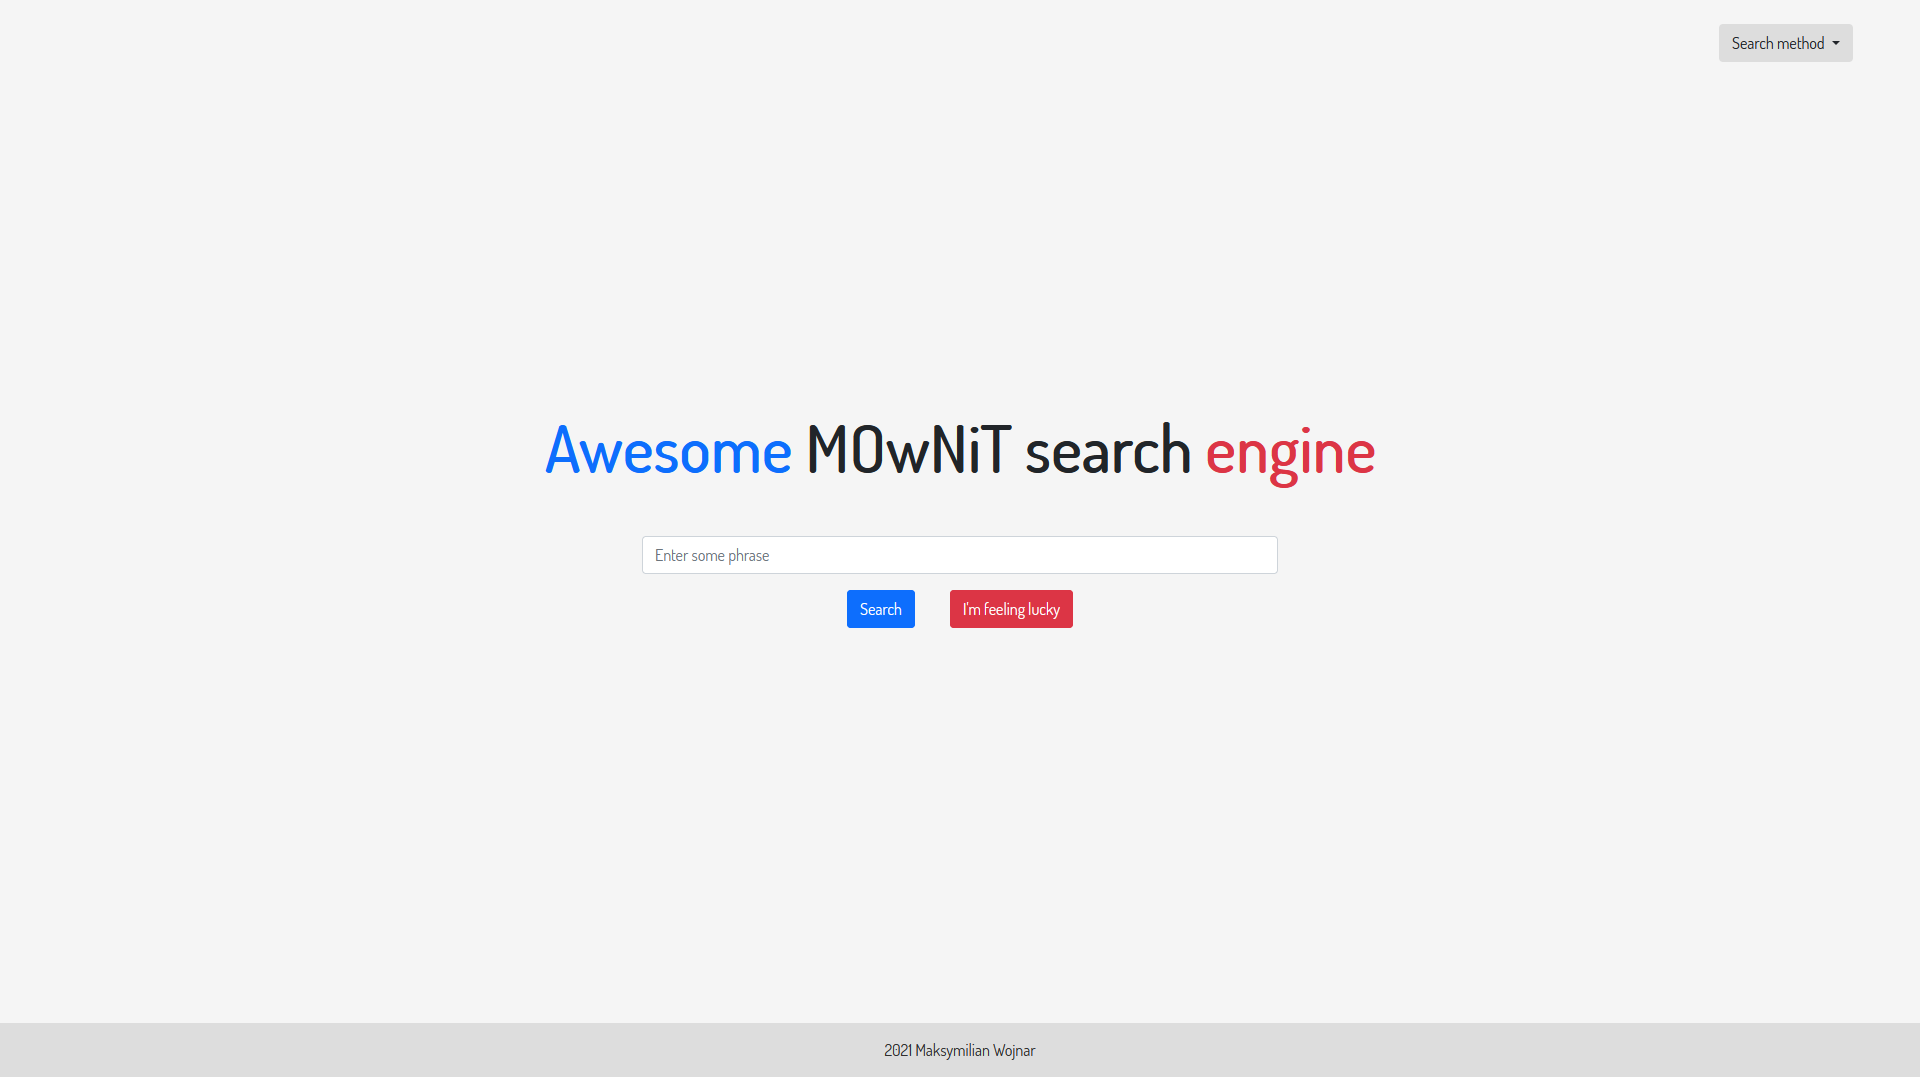

In [3]:
from IPython.display import Image
Image(filename='img/home.png')

W prawym górnym rogu jest możliwość wyboru metody wyszukiwania (VSR, VSR + IDF, LSI, EDLSI). Wyszukiwanie polega na wpisaniu w pole tekstowe hasła oraz naciśnięcia "Search"; dodałem również funkcję analogiczną do wyszukiwarki Google, a więc "I'm feeling lucky" - "Szczęśliwy traf", która wylosuje jednen z rezultatów i otworzy daną stronę.

Po klasycznym wyszukiwaniu, przechodzimy do strony z wynikami:

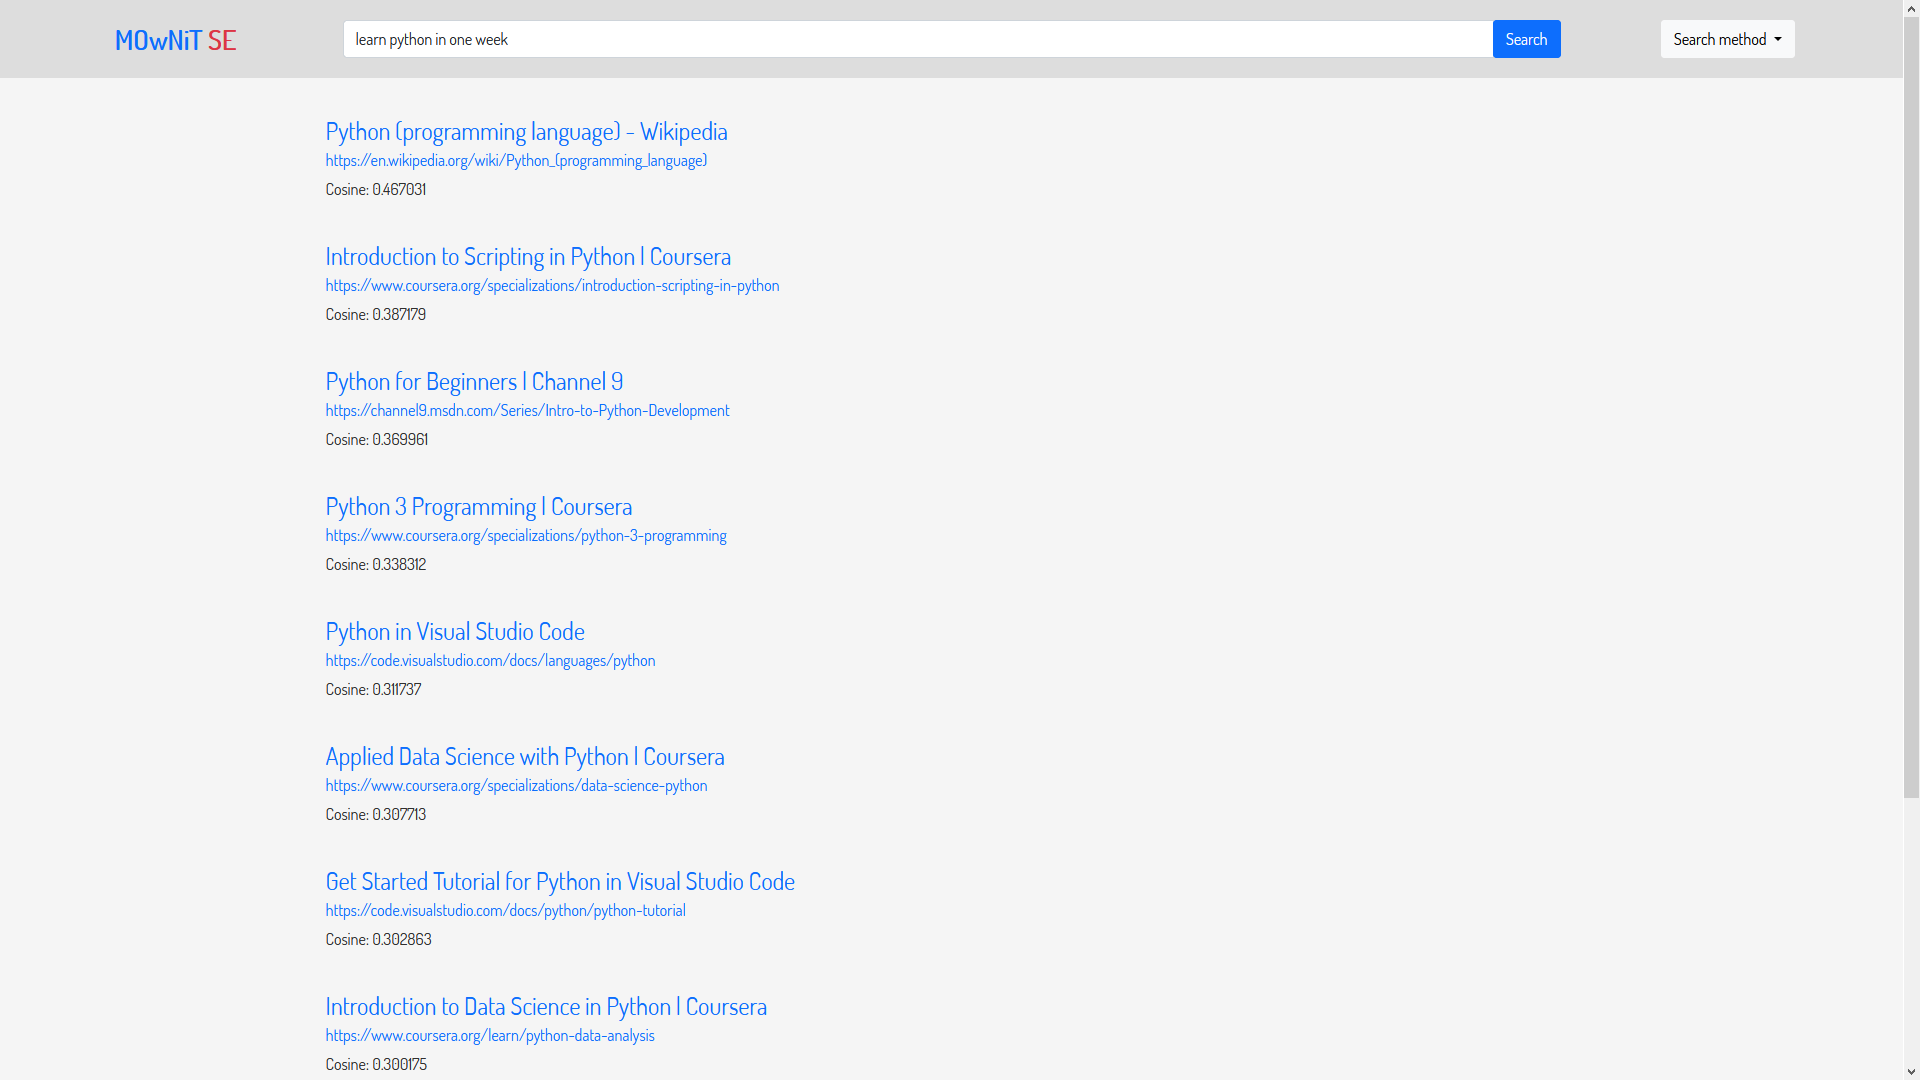

In [4]:
Image(filename='img/results.png')

Każdy z rezultatów wyszukiwania składa się z tytułu strony, linku oraz wartości indeksu dopasowania oznaczonego przez "Cosine". Po kliknięciu w tytuł lub link, przechodzimy do danej strony.

Back-end wyszukiwarki został napisany w Pythonie za pomocą frameworka Flask. Kod znajduje się w pliku app.py; zawiera on wczytywanie środowiska z pliku, funkcje do wyszukiwania haseł różnymi metodami oraz obsługę kilku podstawowych tras:

 - / - strona główna,
 
 - /search/\<method>/\<text> - wyszukiwanie hasła text metodą method,
 
 - /lucky/\<method>/\<text> - funkcja "Szczęśliwy traf" dla hasła text metodą method,
 
 - /save - zapisywanie stanu środowiska.

Aby uruchomić aplikację wyszukiwarki, konieczne są pliki app.py, folder templates oraz pliki ze stanem środowiska shelve.out (nie dołączam ich do sprawozdania, gdyż ich rozmiar w moim przypadku to prawie 1100 MB). Po zainstalowaniu wszystkich wymaganych bibliotek, w linii poleceń należy wpisać "flask run". Aplikacja uruchamia się domyślnie pod adresem http://127.0.0.1:5000.

# Wnioski

## Pobieranie dokumentów

W wyborze strony początkowej dla web crawlera kierowałem się popularnością strony, jej tematyką, ilością odnośników do innych witryn oraz potencjałem do wyszukiwania wartościowych informacji z danej strony. Wybrałem kilka stron, które są agregatami popularnych treści oraz najnowszych wiadomości, na przykład NYT, msn, Reuters czy CNN. Istotnym elementem były różnego rodzaju katalogi, a więc Gutenberg (książki), IMDb (filmy), Coursera (tutoriale) oraz Amazon (zakupy), dzięki którym zapytania dotyczące wymienionych dziedzin, zwracają linki do odpowiednich witryn tematycznych. Ciekawe rezultaty dało również pobieranie stron z Merriam-Webster, który jest Amerykańskim słownikiem języka angielskiego - dzięki temu wyszukiwanie niektórych terminów daje dostęp do słownikowej definicji danego słowa. Najważniejszą pozycją dla mnie była angielska Wikipedia, gdyż zawiera ona dużą liczbę atrykułów (które są zazwyczaj wartościowym wynikiem wyszukiwania) z wielu rónych dziedzin, dlatego najwięcej z pobranych dokumentów pochodzi z Wikipiedii.

## Przetwarzanie tekstu

Wstępne przetwarzanie tekstu przed zliczaniem słów oraz tworzeniem macierzy term-by-document jest bardzo ważnym krokiem w budowie wyszukiwarki. Tokenizacja pozwala na podzielenie tekstu i usunięcie niepotrzebnych symboli, stemming zmniejsza liczbę elementów w słowniku przez wyodrębnienie rdzenia słów, natomiast stoplista pozwala na wykluczenie słów, które pojawiają się bardzo często i nie mają same w sobie dużego znaczenia.

Takie przetwarzanie daje zazwyczaj dobre rezultaty, zarówno dla wydajności wyszukiwarki, jak i jakości wyników, jednak zdarza się, że agresywne przetwarzanie może powodować utratę pierwotnego znaczenia hasła. Poniżej zamieszczam przykład składający się w większości ze słów ze stoplisty, a więc wyrazów, które zostaną usunięte. Przetworzenie tekstu sprawia, że rezultat utracił znaczenie wpisanego hasła:

In [5]:
print(*(t for t in stem_text('I will have a lunch with you when we won\'t have it inside') if t not in stoplist))

lunch insid


## Inverse document frequency

Zastosowanie IDF w wyszukiwarce znacznie poprawiło jakość wyszukiwania. Pierwotna macierz term-by-document zawiera liczności słów w każdym dokumencie, zatem wyszukiwanie z jej pomocą daje wyniki, w których bardzo duże znaczenie mają słowa występujące często. Jeśli używamy słów, które występują rzadko, w połączeniu ze słowami, które występują często, otrzymane rezultaty praktycznie zignorują mało popularne słowo. IDF bardzo dobrze radzi sobie z tym problemem, gdyż obniża lub zwiększa siłę słów odwrotnie proporcjonalnie do częstości ich wykorzystywania. Przez to siła słów w wyszukiwaniu jest znacznie lepiej zbalansowana, a wyszukiwanie rzadkich słów powoduje otrzymanie w pierwszej kolejności tych dokumentów, które zawierają ten wyraz.

Bardzo dobrym przykładem wyszukiwania, które zostało zdominowane przez często występujące słowo, jest "learn python in one week". W przypadku metody VSR, otrzymujemy tylko jeden rezultat związany z Pythonem - pozostałe mają związek z uczeniem się.

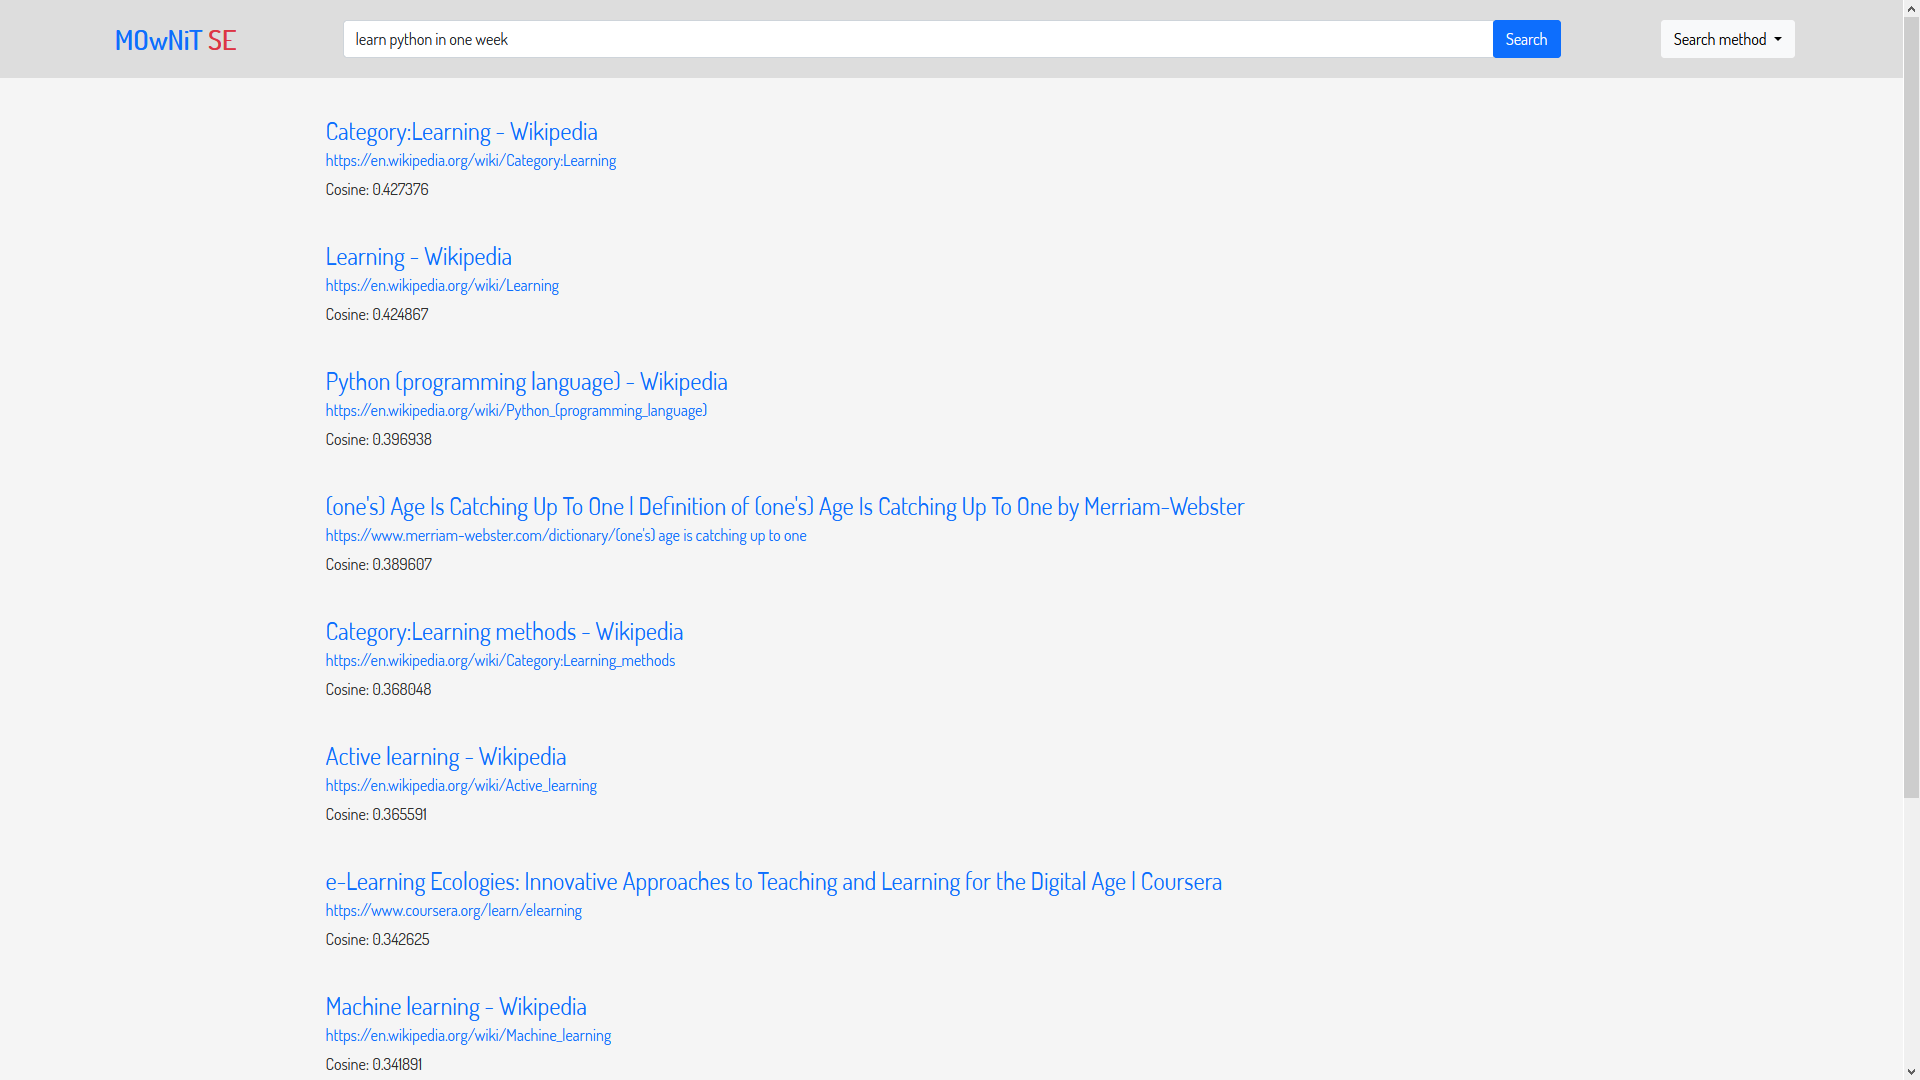

In [6]:
Image(filename='img/python-vsr.png')

Użycie metody VSR + IDF daje wyniki, których oczekiwaliśmy od zapytania:

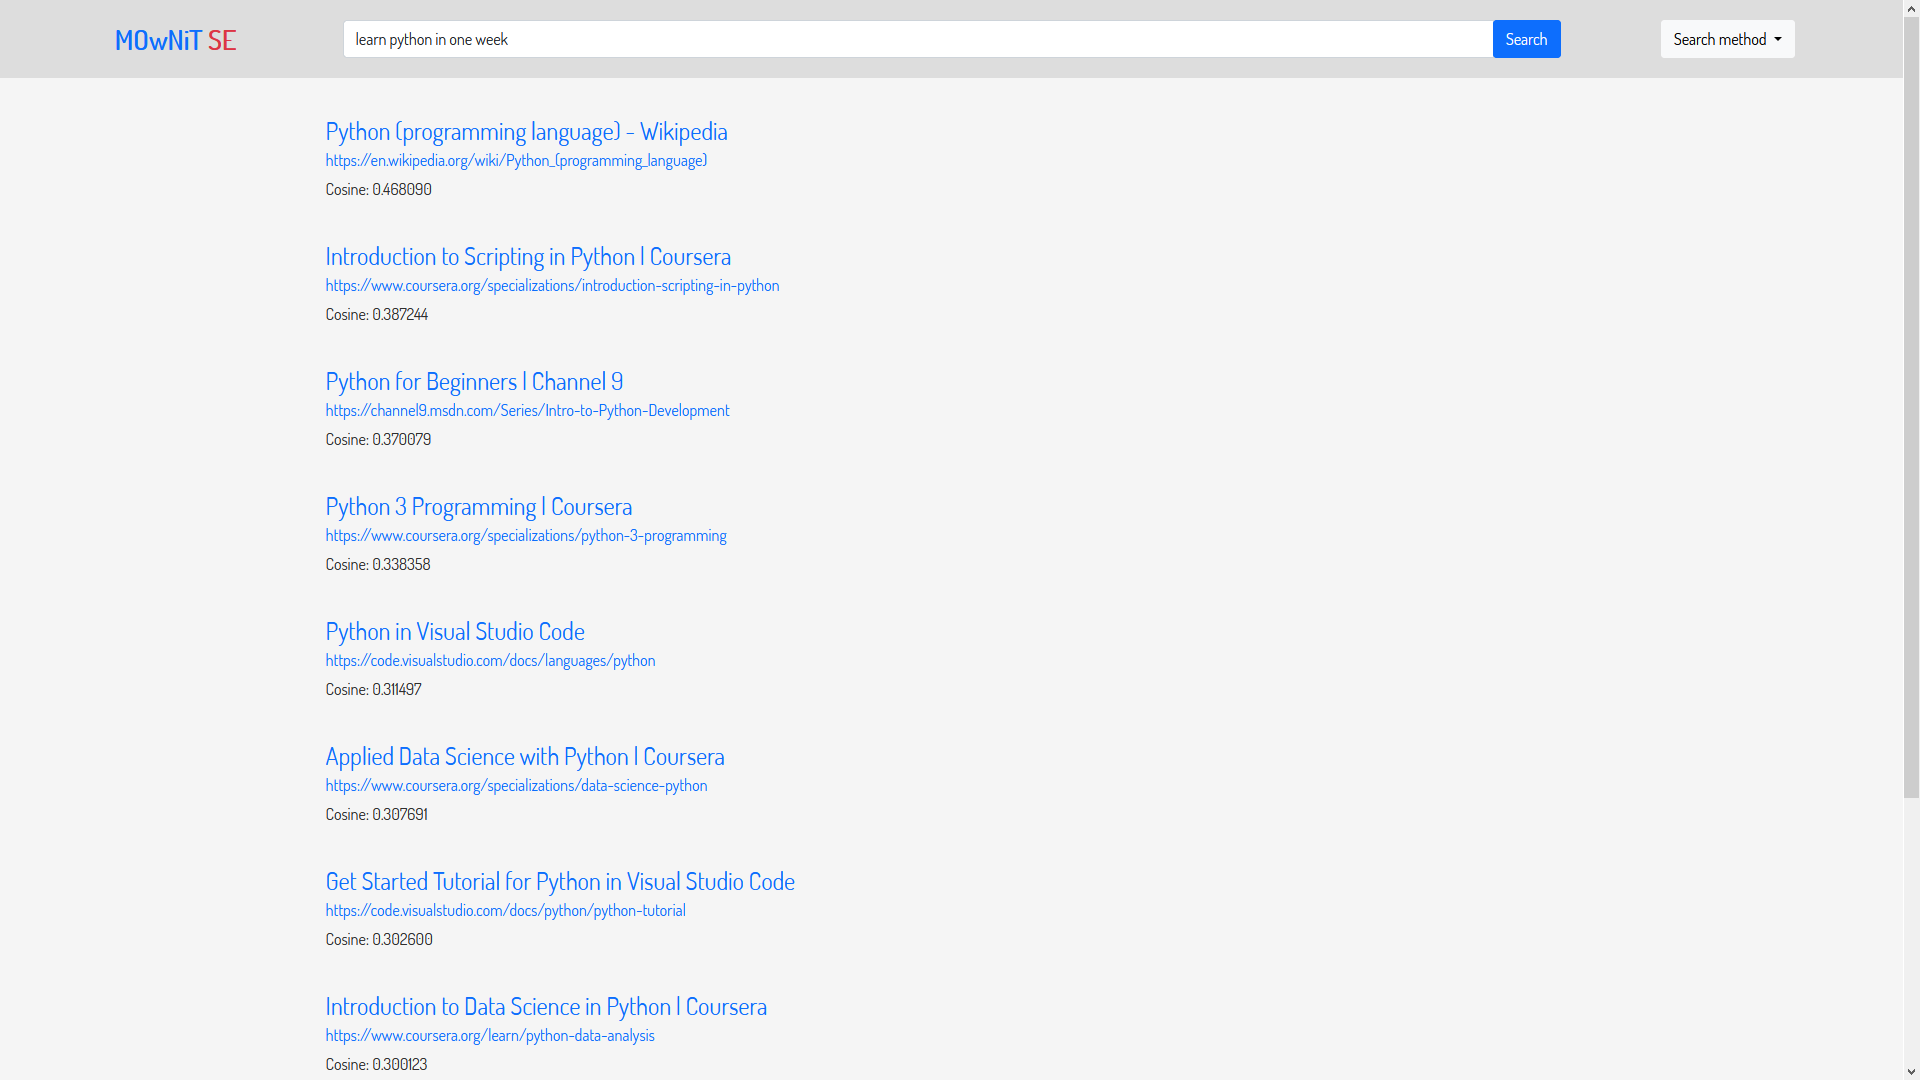

In [7]:
Image(filename='img/python-vsr-idf.png')

## Latent Semantic Indexing

Przeprowadzenie low rank approximation z użyciem faktoryzacji SVD, pozwala na usunięcie szumu z macierzy (w term-by-documet wynika on z tego, że w tym samym dokumencie znajduje się wiele słów z różnych dziedzin), ale również zgrupowanie stron o podobnym znaczeniu. Wybranie największych wartości osobliwych macierzy powoduje, że w wektorach własnych pojawiają się słowa bliskoznaczne oraz funkcjonujące w tej samej tematyce. Umożliwia to zwracanie wyników wyszukiwania, w których niekoniecznie występują słowa kluczowe z hasła, lecz także takie, które są powiązane z szukaną frazą. W moim przypadku było to zbyt intensywne działanie i zdarzało się, że wyniki były skorelowane z tematem hasła, jednak nie udało się uzyskać takich rezultatów, które odpowiadałyby bezpośrednio na wpisane hasło. Być może jest to spowodowane niską wartością $k = 150$, jednak ze względu na możliwości obliczeniowe, nie byłem w stanie przetestować większych wartości tego parametru.

Działanie low rank approximation widać dobrze na poniższym przykładzie. Sama "Alicja w krainie czarów" pojawia się dopiero na 10 miejscu, jednak trzeba zauważyć, że prawie wszystkie wyszukiwania są związane z książkami dla dzieci.

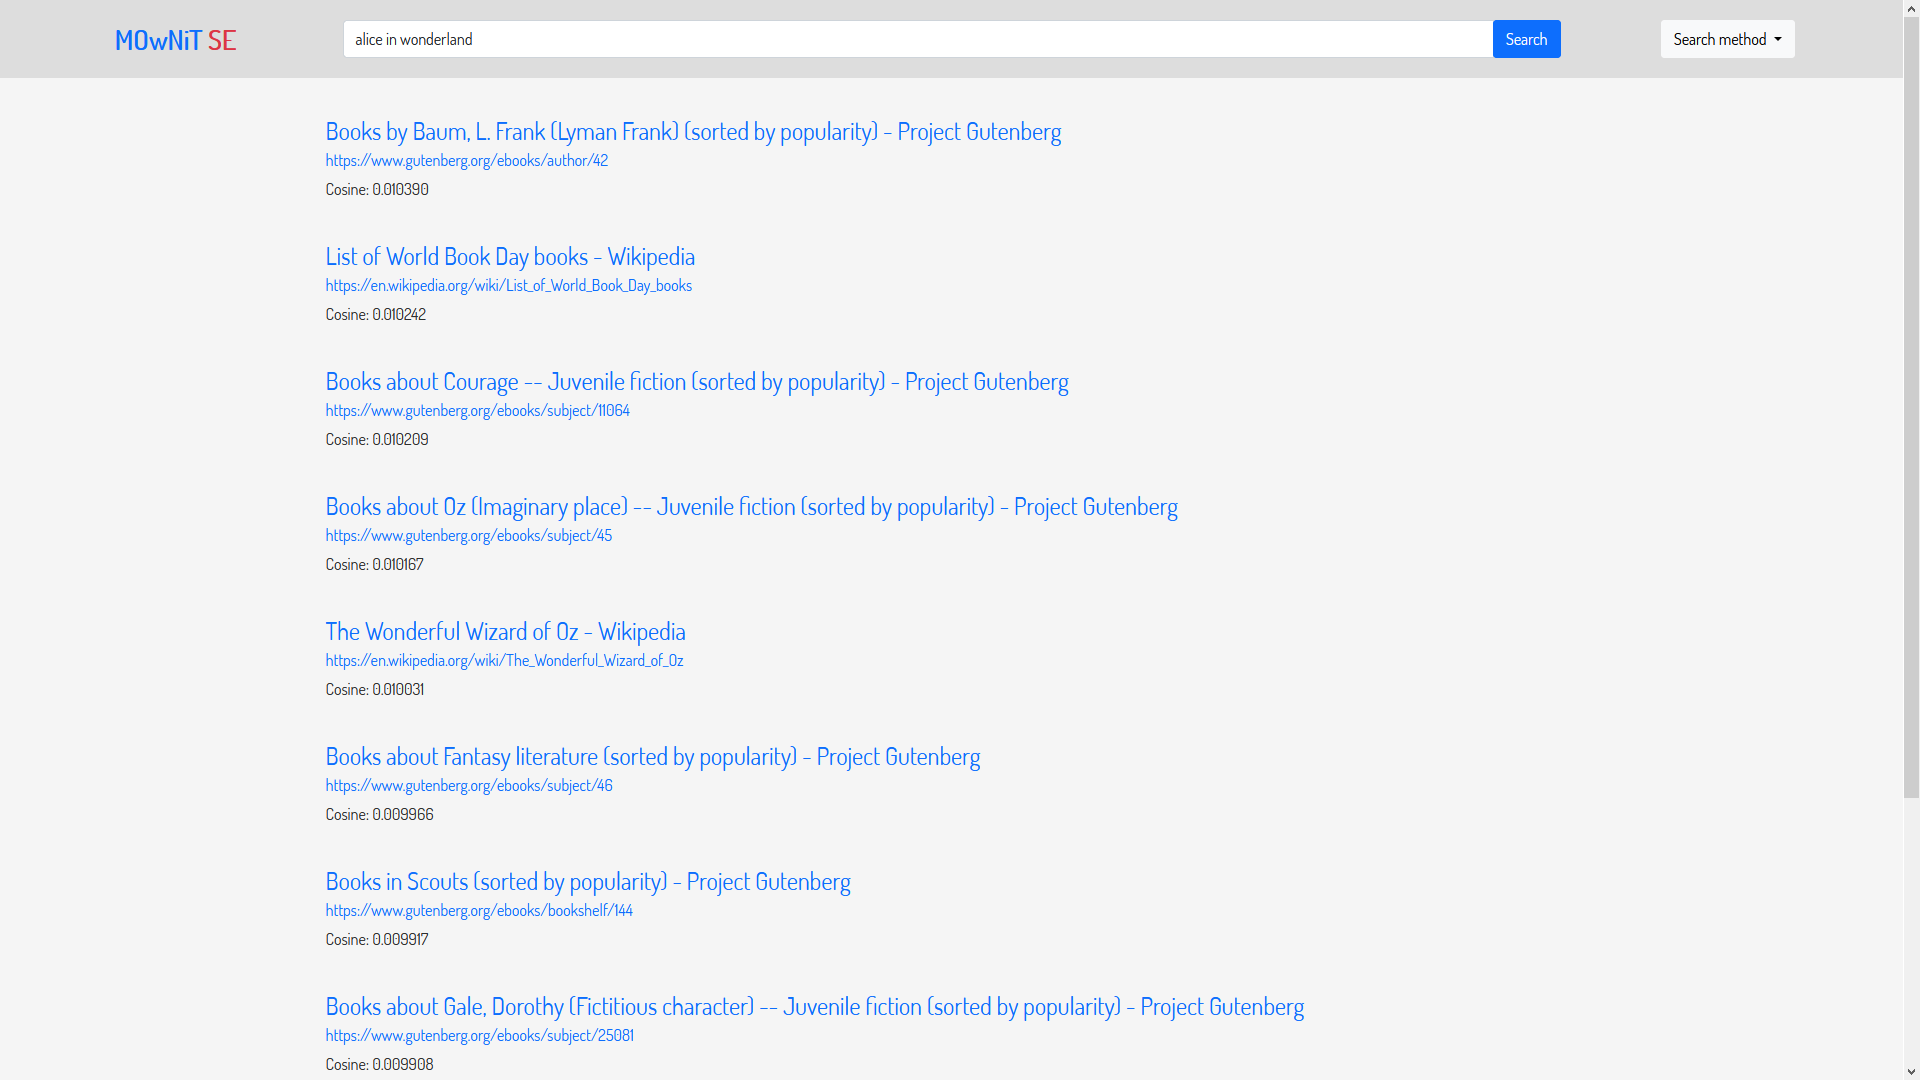

In [8]:
Image(filename='img/alice-lsi.png')

Dla porównania zamieszczam to samo wyszukiwanie w metodzie EDLSI:

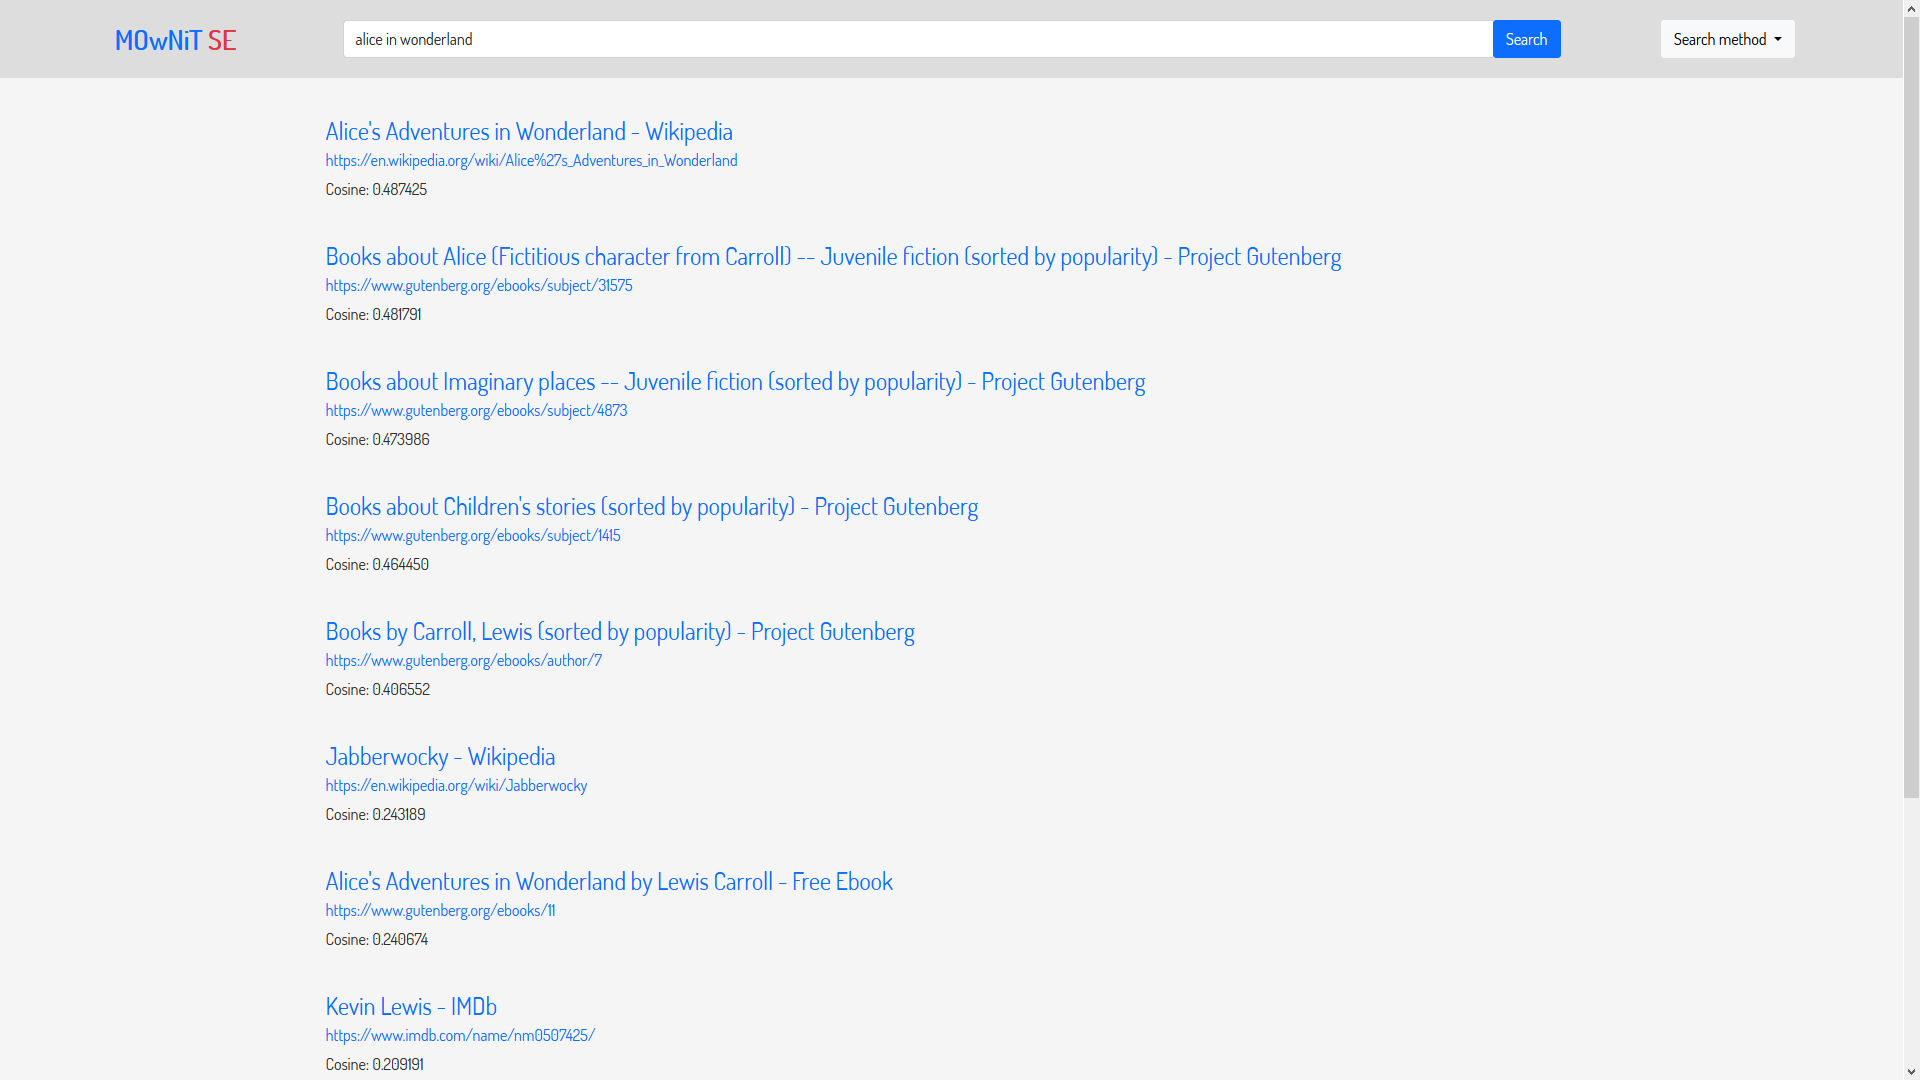

In [9]:
Image(filename='img/alice-edlsi.png')

LSI może powodować również utratę siły rzadko występujących terminów, widać to przy wyszukiwaniu "brad pitt films". Rezultaty są albo bezpośrednio powiązane z aktorem albo w ogóle nie zawierają jego nazwiska.

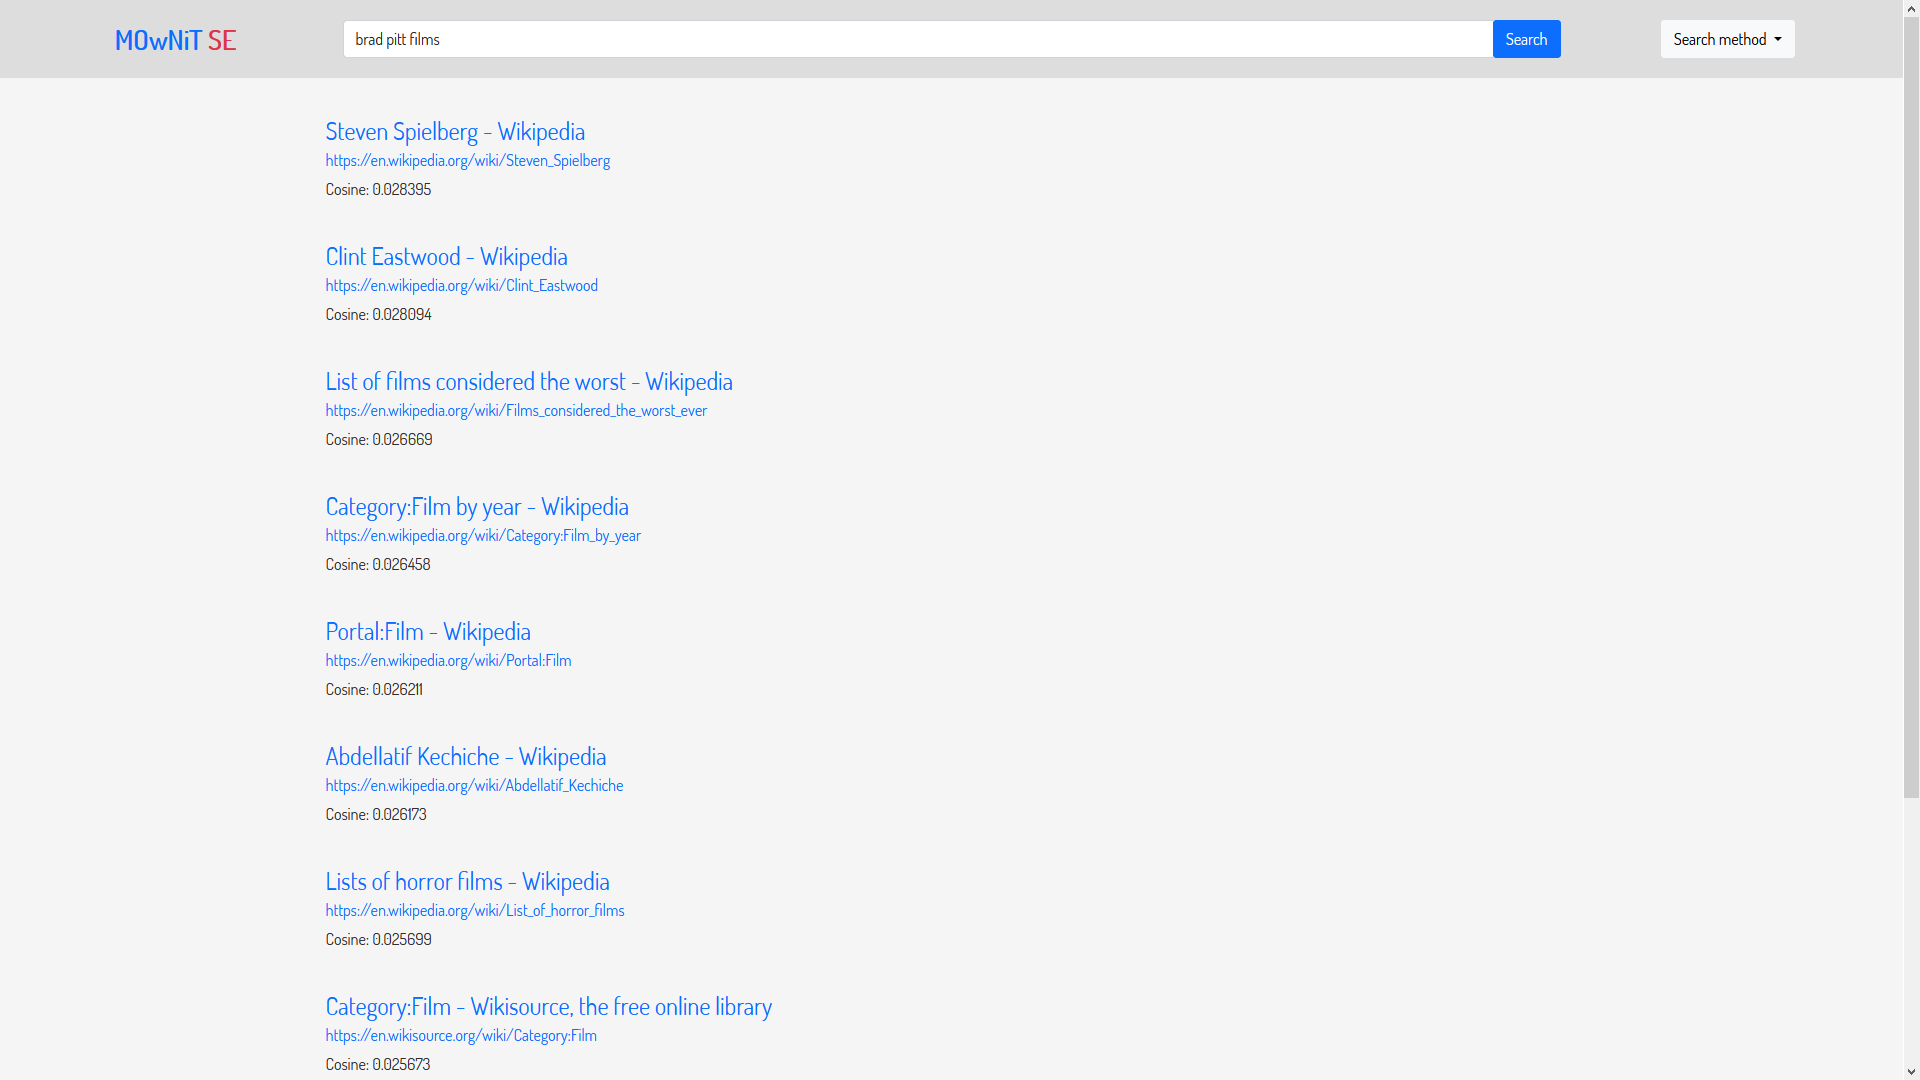

In [10]:
Image(filename='img/pitt-lsi.png')

W tym wypadku z pytaniem lepiej poradziła sobie nawet podstawowa metoda VSR:

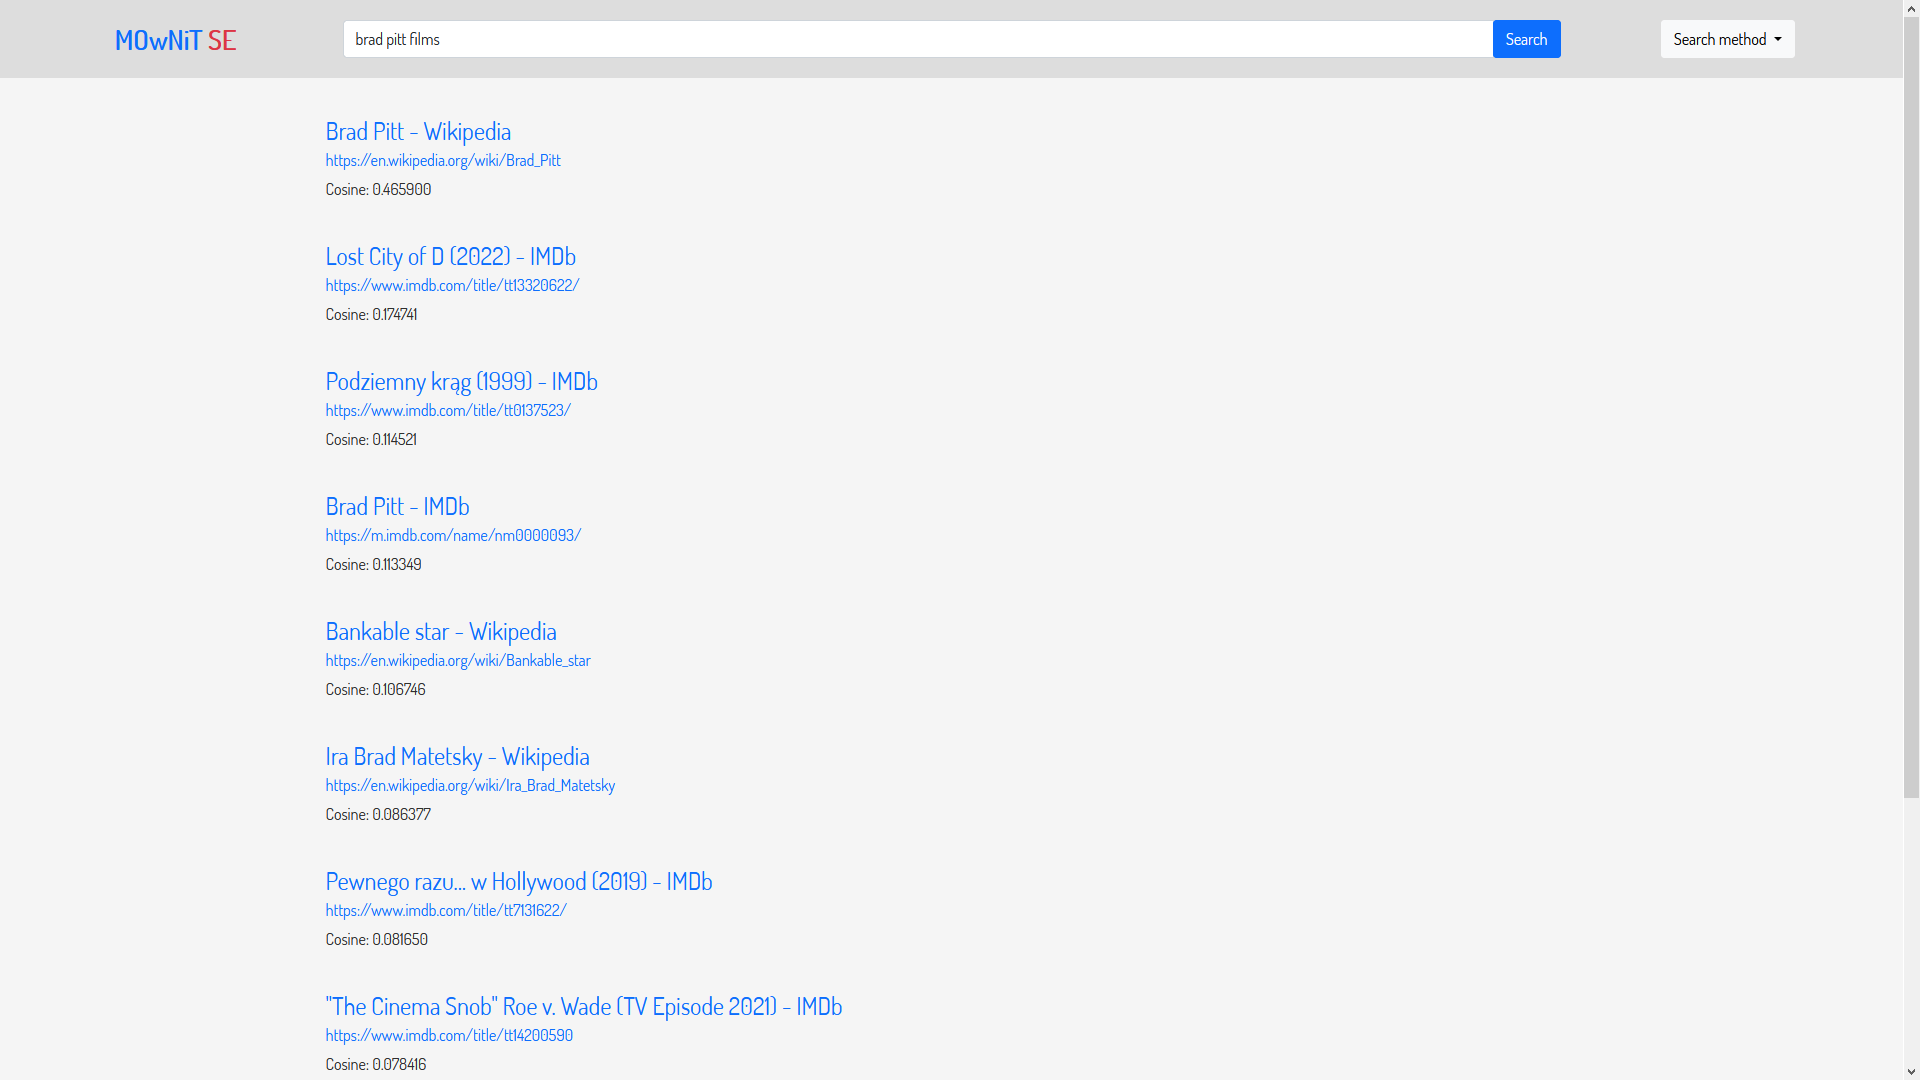

In [11]:
Image(filename='img/pitt-vsr.png')

(polskie tytuły stron pojawiają się tutaj z powodu zwracania przez stronę tytułów znanych w danym kraju, same dokumenty są po angielsku)

Metoda ta ma jednak wielką przewagę, gdy pod uwagę weźmiemy hasła, które nie wyrażają bezpośrednio naszego pytania. Dla przykładu hasło "1945" nasuwa oczywiste skojarzenia z II wojną światową. LSI doskonale rozpoznała to powiązanie i zwróciła odpowiednie wyniki:

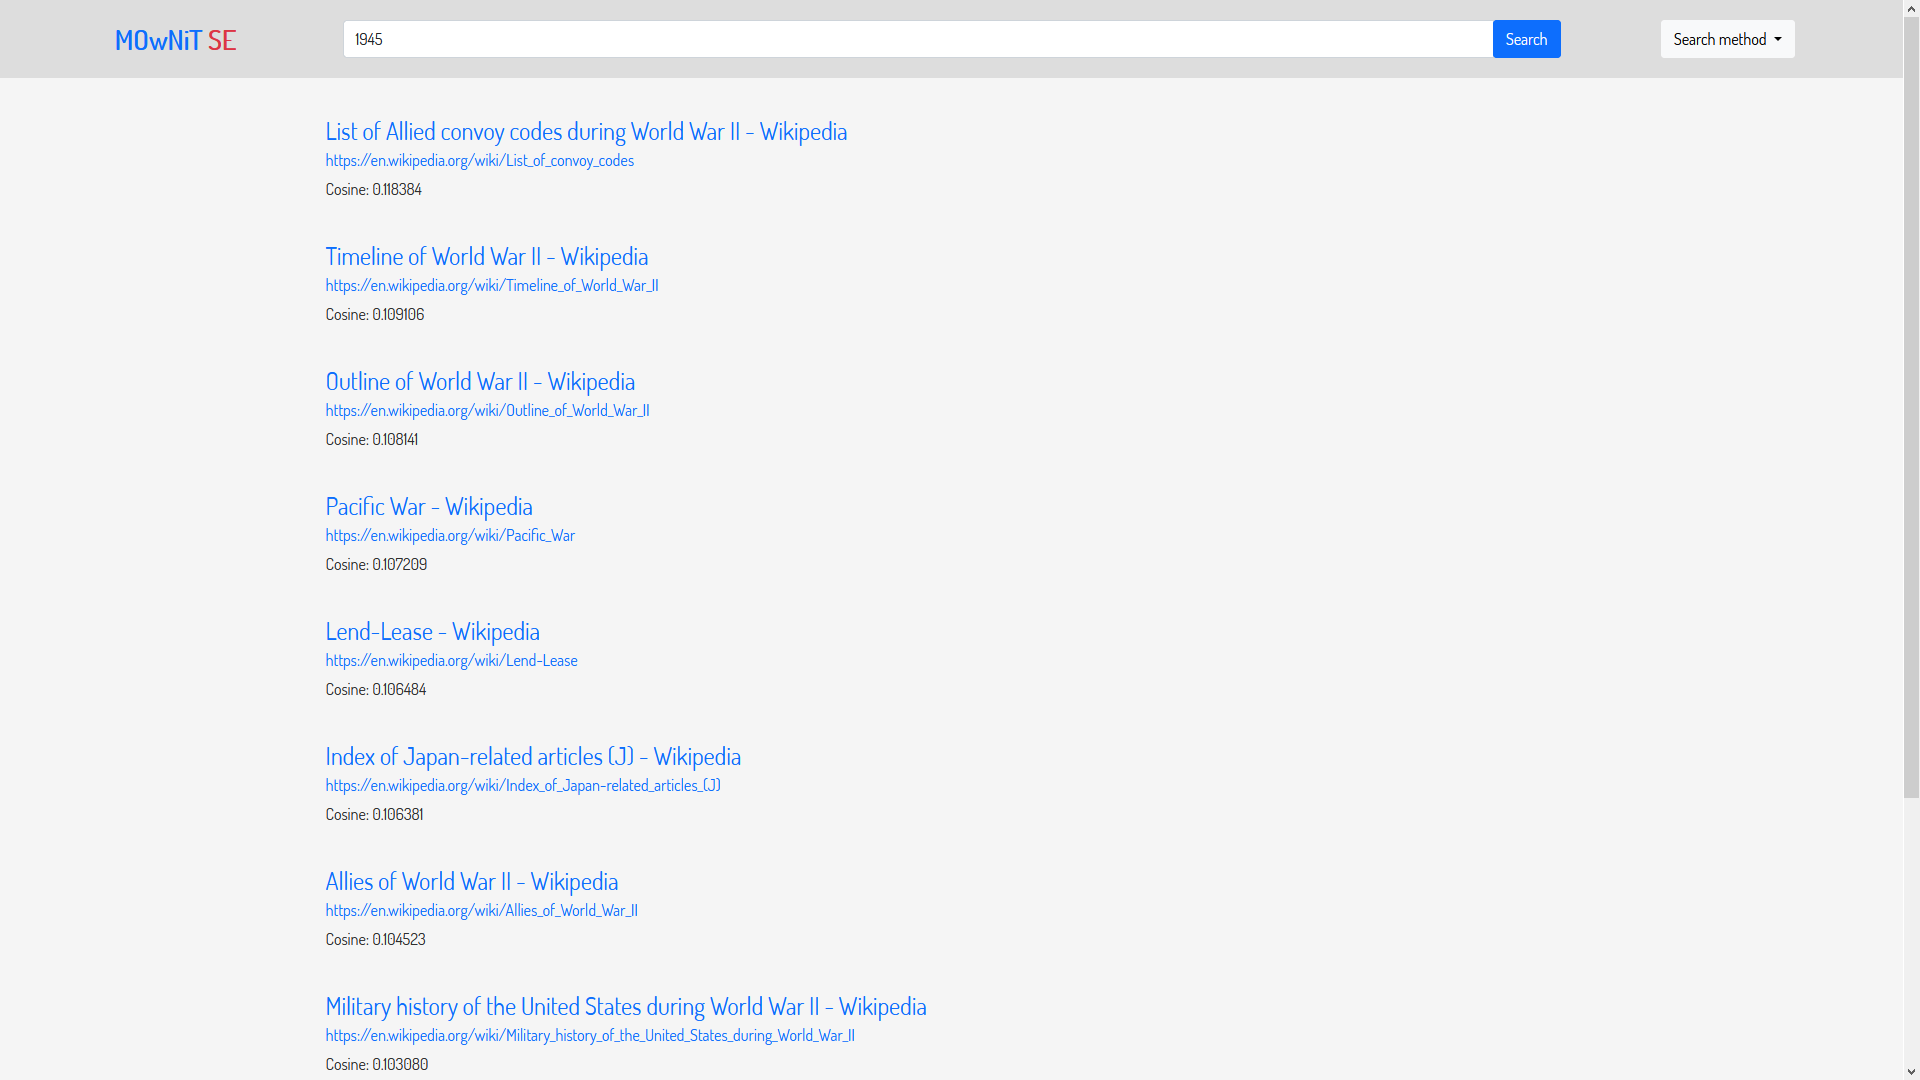

In [12]:
Image(filename='img/1945-lsi.png')

Wyszukiwania z innymi metodami nie dają już tak dobrych rezultatów, dla porównania zamieszczam rezultaty z metodą EDLSI:

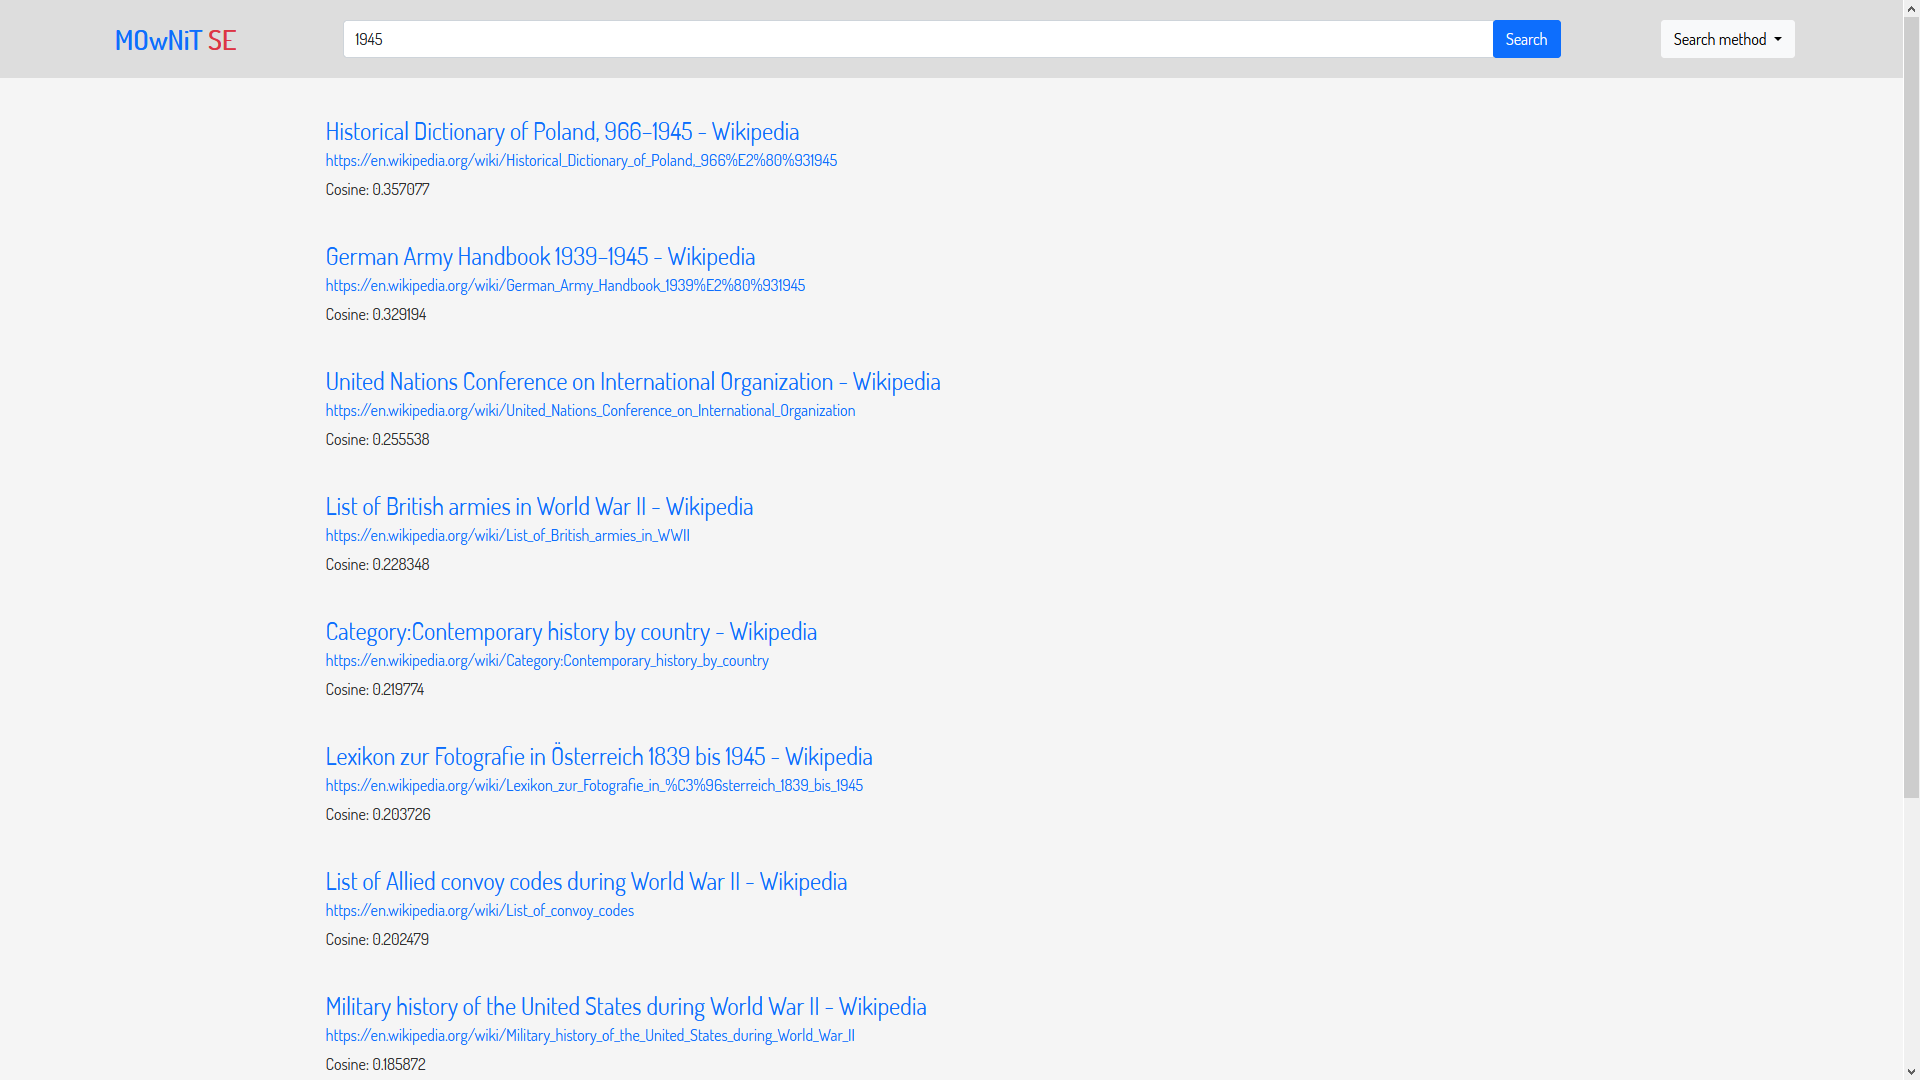

In [13]:
Image(filename='img/1945-edlsi.png')

## Essential Dimensions of Latent Semantic Indexing

Rozwiązaniem problemów z LSI (a więc złożoności obliczeniowej oraz uzyskiwaniu wyników związanych z tematem, a nie treścią hasła) było zastosowanie EDLSI. Użycie mniejszej liczby wymiarów spowodowało znacznie przyspieszenie działania wyszukiwarki, a dodanie macierzy term-by-document z wagami przywróciło siłę mało popularnym słowom. Zastosowanie parametru $x = 0.2$ spowodowało przewagę macierzy term-by-document nad macierzą low rank approximation, dlatego wyniki są identyczne lub bardzo zbliżone to metody SVR + IDF. Być może dopasowanie odpowiedniej wartości parametrów $x$ oraz $k$ polepszyłoby jeszcze jakość wyszukiwań, należałoby jednak przeprowadzić o wiele więcej testów oraz przygotować odpowiednie zbiory testowe i funkcje kosztu, aby umożliwić liczbowe porównywanie wyników wyszukiwań.

Zamieszczam poniżej jedno z ciekawszych wyszukiwań z EDLSI - "covid 19" - w którym 3 z 10 wyszukiwań to adresy ministerstw zdrowia Indii, stanu New Mexico oraz stanu West Virginia.

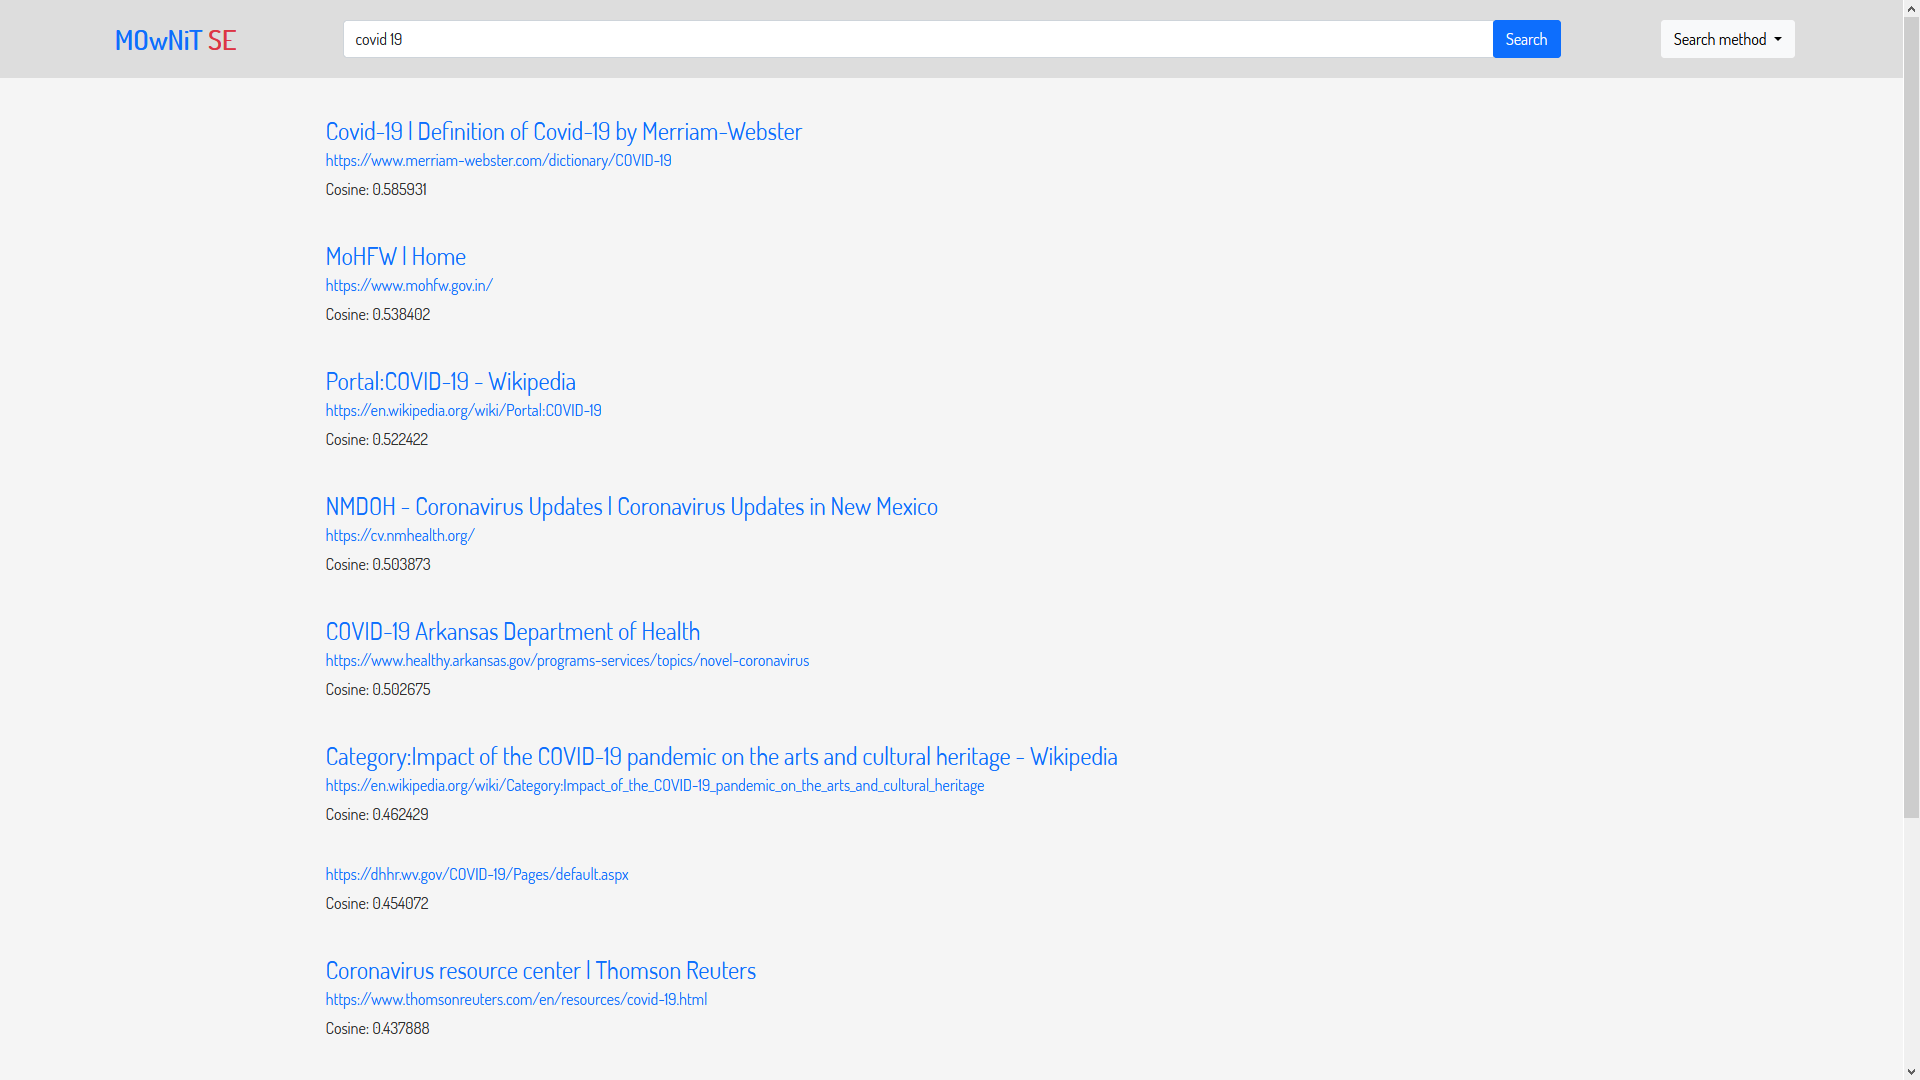

In [14]:
Image(filename='img/covid-edlsi.png')

## Najciekawsze hasła

Screenshoty z wynikami wyszukiwań tych haseł zamieszczam w katalogu "img".

 - alice in wonderland,
 
 - the war to end all wars,
 
 - tallest building in the world,
 
 - learn python in one week,
 
 - deleterious mutation,
 
 - covid 19,
 
 - joe biden,
 
 - brad pitt films,
 
 - what is the meaning of cabriolet,
 
 - money,
 
 - 1945.